<a href="https://colab.research.google.com/github/gsarm78/cs230Project/blob/master/models/model2_coder_decoder/Model2_nowcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/gsarm78/cs230Project.git
print("[INFO] Git repo cloned")

fatal: destination path 'cs230Project' already exists and is not an empty directory.
[INFO] Git repo cloned


In [2]:
import numpy as np
from PIL import Image, ImageEnhance
import os
import time
import pylab as plt
import pickle
from pathlib import Path
from sklearn.metrics import classification_report

import tensorflow.compat.v1 as tf
import tensorflow.compat.v1.keras as keras
import tensorflow.compat.v1.keras.backend
from tensorflow.compat.v1.keras.models import Sequential, Model, load_model, model_from_json
from tensorflow.compat.v1.keras.layers import Input, Add, Conv2D, Conv3D, Conv2DTranspose, Concatenate, TimeDistributed, BatchNormalization, ConvLSTM2D, BatchNormalization, LeakyReLU, MaxPooling2D, UpSampling2D, TimeDistributed, MaxPooling2D, UpSampling2D, Lambda, Dropout, Flatten, Reshape
from tensorflow.compat.v1.keras.optimizers import *
from tensorflow.compat.v1.keras.preprocessing.image import ImageDataGenerator
from tensorflow.compat.v1.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.compat.v1.keras.callbacks import ModelCheckpoint


import logging
logging.getLogger('tensorflow').setLevel(logging.DEBUG)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  ### NO WARNINGS!
tf.__version__
print("[INFO] Imports loaded.")


[INFO] Imports loaded.


In [23]:
# DATA LOADING AND PROCESSING INTO NUMPY ARRAY

IMAGE_PATH = '/content/cs230Project/samples'


WIDTH = 64
HEIGHT = 64
IMG_SEQUENCE = np.array([])
INPUT_SEQUENCE = np.array([])
NEXT_SEQUENCE = np.array([])
NUMBER = 0

def image_initialize(image):
    picture = Image.open(image)
    picture = picture.crop((243, 176, 1428, 1280))
    picture = picture.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
    picture = picture.convert('L')
    data = np.array(picture.getdata()).reshape(WIDTH, HEIGHT, 1)
    return data

for file in os.listdir(IMAGE_PATH):
    image_array = image_initialize(os.path.join(IMAGE_PATH, file))
    IMG_SEQUENCE = np.append(IMG_SEQUENCE, image_array)
    NUMBER += 1

IMG_SEQUENCE = IMG_SEQUENCE.reshape(NUMBER, WIDTH * HEIGHT)
print(IMG_SEQUENCE.shape)

for i in IMG_SEQUENCE:
    for j in range(int(len(i))):
        if i[j] < 50:
            i[j] = 0

#np.savez('/content/cs230Project/data/images_sequence_array.npz', sequence_array=IMG_SEQUENCE) # test
np.savez('/content/cs230Project/data/images_sequence_array.npz', sequence_array=IMG_SEQUENCE) # original
print('[INFO] Data (images) saved as numpy compressed array')
print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()))

(80, 4096)
[INFO] Data (images) saved as numpy compressed array
2020-03-15 19:40:48


In [24]:
# LOADING OF NUMPY ARRAY INTO SEQUENCES #
#########################################

FRAMES = 20 #frames to process

IMG_SEQUENCE = np.load('/content/cs230Project/data/images_sequence_array.npz')['sequence_array']  # load array
print('[INFO] Image Sequence Data loaded.')
#print('[INFO]', IMG_SEQUENCE.shaoe)
print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()))



# Number of input images in the sequence
NUMBER = len(IMG_SEQUENCE)

IMG_SEQUENCE = IMG_SEQUENCE.reshape(NUMBER, WIDTH, HEIGHT, 1)
print(IMG_SEQUENCE.shape)

[INFO] Image Sequence Data loaded.
2020-03-15 19:40:48
(80, 64, 64, 1)


In [25]:
INPUT_SEQUENCE = np.zeros((NUMBER-FRAMES, FRAMES, WIDTH, HEIGHT, 1), dtype=float)
NEXT_SEQUENCE = np.zeros((NUMBER-FRAMES, FRAMES, WIDTH, HEIGHT, 1), dtype=float)



#######
# report pixel means and standard deviations
#print('[INFO] IMG_SEQUENCE Statistics train=%.3f (%.3f)' % (IMG_SEQUENCE.mean(), IMG_SEQUENCE.std()))
#mean substraction
#IMG_SEQUENCE -=np.mean(IMG_SEQUENCE)
#print('[INFO] IMG_SEQUENCE after Zero centred train=%.3f (%.3f)' % (IMG_SEQUENCE.mean(), IMG_SEQUENCE.std()))
#IMG_SEQUENCE /= np.std(IMG_SEQUENCE)
#print('normalised train=%.3f (%.3f)' % (IMG_SEQUENCE.mean(), IMG_SEQUENCE.std()))
########

for i in range(FRAMES):
    #print(i)
    INPUT_SEQUENCE[:, i, :, :, :] = IMG_SEQUENCE[i:i+NUMBER-FRAMES]
    NEXT_SEQUENCE[:, i, :, :, :] = IMG_SEQUENCE[i+1:i+NUMBER-FRAMES+1]

print('[INFO] InputSeq Statistics=%.3f (%.3f)' % (INPUT_SEQUENCE.mean(), INPUT_SEQUENCE.std()))
print('[INFO] NextSeq Statistics=%.3f (%.3f)' % (NEXT_SEQUENCE.mean(), NEXT_SEQUENCE.std()))

print(INPUT_SEQUENCE.shape)
print(NEXT_SEQUENCE.shape) 
print("[INFO] Input sequence ready")

[INFO] InputSeq Statistics=8.375 (31.395)
[INFO] NextSeq Statistics=8.371 (31.389)
(60, 20, 64, 64, 1)
(60, 20, 64, 64, 1)
[INFO] Input sequence ready


In [26]:
'''
import numpy as np
import matplotlib.pyplot as plt
import time
from pathlib import Path

import tensorflow.compat.v1 as tf
import tensorflow.compat.v1.keras as keras

from tensorflow.compat.v1.keras.models import Model, load_model
from tensorflow.compat.v1.keras.layers import Input, Conv2D, ConvLSTM2D, Dense, Conv2DTranspose, SeparableConv2D
from tensorflow.compat.v1.keras.layers import MaxPooling2D, UpSampling2D, Lambda, Dropout, Flatten, Reshape
from tensorflow.compat.v1.keras.layers import TimeDistributed, BatchNormalization, Concatenate
from tensorflow.compat.v1.keras.callbacks import ModelCheckpoint

tf.__version__
'''

'\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport time\nfrom pathlib import Path\n\nimport tensorflow.compat.v1 as tf\nimport tensorflow.compat.v1.keras as keras\n\nfrom tensorflow.compat.v1.keras.models import Model, load_model\nfrom tensorflow.compat.v1.keras.layers import Input, Conv2D, ConvLSTM2D, Dense, Conv2DTranspose, SeparableConv2D\nfrom tensorflow.compat.v1.keras.layers import MaxPooling2D, UpSampling2D, Lambda, Dropout, Flatten, Reshape\nfrom tensorflow.compat.v1.keras.layers import TimeDistributed, BatchNormalization, Concatenate\nfrom tensorflow.compat.v1.keras.callbacks import ModelCheckpoint\n\ntf.__version__\n'

In [27]:
# Bring dataset in shape
xs = INPUT_SEQUENCE
xs = xs.astype(np.float32)
xs = xs / np.max(xs)
#xs = np.swapaxes(xs, 0, 1)  # swap frames and observations so [obs, frames, height, width, channels]
#xs = np.expand_dims(xs, -1) #Add channel dimension
print(f"Dataset shape: {xs.shape}")
print('[INFO] InputSeq Statistics=%.3f (%.3f)' % (xs.mean(), xs.std()))

Dataset shape: (60, 20, 64, 64, 1)
[INFO] InputSeq Statistics=0.038 (0.143)


In [0]:
# Motion Diff Input for Motion Encoder
def motion_diff(x):
    seqLen = len(x[0])
    return np.asarray([[x[n][i]-x[n][i-1] for i in range(1,seqLen)] for n in range(len(x))])

In [0]:
# Hyperparameters
end = 50  #8000
seqLen = 10
x_dim, y_dim, c_dim = 64, 64, 1
fs = (5,5)  # filter size for convolutional kernels
nk = 64     # number of kernels for conv layers #48 
nd = 2048    # number of neurons in dense layers #192

In [0]:
smooth=1e-9
  #Additional metrics: SSIM, PSNR, POD, FAR
def ssim(x, y, max_val=1.0):
  return tf.image.ssim(x, y, max_val)

def psnr(x, y, max_val=1.0):
  return tf.image.psnr(x, y, max_val)

  #recall
def POD(x, y):
  y_pos = keras.backend.clip(x, 0, 1)
  y_pred_pos = keras.backend.clip(y, 0, 1)
  y_pred_neg = 1 - y_pred_pos
  tp = keras.backend.sum(y_pos * y_pred_pos)
  fn = keras.backend.sum(y_pos * y_pred_neg)
  return (tp+smooth)/(tp+fn+smooth)

def FAR(x, y):
  y_pred_pos = keras.backend.clip(y, 0, 1)
  y_pos = keras.backend.clip(x, 0, 1)
  y_neg = 1 - y_pos
  tp = keras.backend.sum(y_pos * y_pred_pos)
  fp = keras.backend.sum(y_neg * y_pred_pos)
  return (fp)/(tp+fp+smooth)

metrics = ['accuracy', ssim, psnr, POD, FAR]

In [0]:
# Inputs
dtype='float32'
contentInput = Input(shape=(x_dim, y_dim, c_dim), name='content_input', dtype=dtype)
motionInput = Input(shape=(None, x_dim, y_dim, c_dim), name='motion_input', dtype=dtype)

# Content Encoder
x = Conv2D(nk, fs, activation='relu', padding='same', name='content_conv_1')(contentInput)
x = Conv2D(nk, fs, activation='relu', padding='same', name='content_conv_new1')(x) #new
x = MaxPooling2D((2,2), name='content_pool_1')(x)
#x = BatchNormalization()(x) #new
x = Conv2D(nk*2, fs, activation='relu', padding='same', name='content_conv_2')(x)
x = Conv2D(nk*2, fs, activation='relu', padding='same', name='content_conv_new2')(x) #new
x = MaxPooling2D((2,2), name='content_pool_2')(x)
#x = Dropout(rate=0.5, name='dropout')(x)
#x = BatchNormalization()(x)#new
x = Conv2D(nk*4, fs, activation='relu', padding='same', name='content_conv_3')(x)
x = Conv2D(nk*4, fs, activation='relu', padding='same', name='content_conv_new3')(x) #new
x = Conv2D(nk*4, fs, activation='relu', padding='same', name='content_conv_new3-2')(x) #new
contentEnc = MaxPooling2D((2,2), name='content_pool_3')(x)
#x = BatchNormalization()(x)#new
#x = Flatten()(x)
#contentEnc = Dense(nd*4, activation='relu', name='content_latent')(x)

# Motion Encoder
# Layer 1
tcnv1 = TimeDistributed(Conv2D(nk, (5,5), activation='relu', padding='same'), name='motion_conv_1')(motionInput) 
x = TimeDistributed(MaxPooling2D((2,2)), name='motion_pool_1')(tcnv1) #original (2,2)
# Layer 2
tcnv2 = TimeDistributed(Conv2D(nk, (5,5), activation='relu', padding='same'), name='motion_conv_2')(x)
x = TimeDistributed(MaxPooling2D((2,2)), name='motion_pool_2')(tcnv2)
# Layer 3
tcnv3 = TimeDistributed(Conv2D(nk, (7,7), activation='relu', padding='same'), name='motion_conv_3')(x)
x = TimeDistributed(MaxPooling2D((2,2)), name='motion_pool_3')(tcnv3)
# Layer 4
motionEnc = ConvLSTM2D(nk*8, (8,8), activation='relu', padding='same', return_sequences=False, dropout=0.4, recurrent_dropout=0.4, name='motion_lstm', dtype=dtype)(x)
#x = Flatten()(x)
#motionEnc = Dense(nd*4, activation='relu', name='motion_latent')(x) #relu #sigmoid before

# Combination
x = Concatenate(name='concat_layer')([contentEnc, motionEnc])  #contentEnc, motionEnc
x = Conv2D(nk*4, (3, 3), activation='relu', padding='same', name='comb_conv_1')(x)
x = Conv2D(nk*2, (3, 3), activation='relu', padding='same', name='comb_conv_new1')(x) #new
combined = Conv2D(nk*4, (3, 3), activation='relu', padding='same', name='comb_conv_new1-2')(x)

# Residuals
res3 = Lambda(lambda x: x[:,-1])(tcnv3)
res2 = Lambda(lambda x: x[:,-1])(tcnv2)
res1 = Lambda(lambda x: x[:,-1])(tcnv1)

# Decoder
x = UpSampling2D((2,2), name='decoder_upsample_1')(combined)
x = Conv2DTranspose(nk*4, fs, activation='relu', padding='same', name='decoder_conv_1')(x)
x = Conv2DTranspose(nk*4, fs, activation='relu', padding='same', name='decoder_conv_new1')(x) #new
x = Conv2DTranspose(nk*2, fs, activation='relu', padding='same', name='decoder_conv_new1-2')(x) #new

x = Concatenate()([x, res3]) #res3
x = UpSampling2D((2,2), name='decoder_upsample_2')(x)
x = Conv2DTranspose(nk*4, fs, activation='relu', padding='same', name='decoder_conv_2')(x)
x = Conv2DTranspose(nk*4, fs, activation='relu', padding='same', name='decoder_conv_new2')(x) #new

x = Concatenate()([x, res2])
x = UpSampling2D((2,2), name='decoder_upsample_3')(x)
x = Conv2DTranspose(nk*4, fs, activation='relu', padding='same', name='decoder_conv_3')(x)
x = Concatenate()([x, res1]) #res1
#x = BatchNormalization()(x)
predictions = Conv2DTranspose(1, fs, activation='tanh', padding='same', name='prediction')(x) #sigmoid original

#custom loss function
def weight_loss(y_true,y_pred):
    pw = 2
    ytrue = keras.backend.flatten(y_true)
    ypred = keras.backend.flatten(y_pred)
    return tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(logits=ypred,targets=ytrue,pos_weight=pw))


# Create and compile model
model = Model(inputs= [contentInput, motionInput], outputs=predictions)

optim = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='mse', optimizer=optim, metrics=metrics) #mse 

#model.summary()

In [0]:
#Visualise Model Topology and save to file (model.png)
#from keras.utils import plot_model
#plot_model(model, show_shapes=True, to_file='/model.png')

In [0]:
# Data
train_x = [xs[:end,seqLen-2], motion_diff(xs[:end,:seqLen-1])]  #list

# train_x = motion_diff(xs[:end,:seqLen-1])

train_y = xs[:end,seqLen-1]

val_x   = [xs[end:,seqLen-2], motion_diff(xs[end:,:seqLen-1])]

# val_x   = motion_diff(xs[end:,:seqLen-1])

val_y   = xs[end:,seqLen-1]

In [0]:
#Define Class to track performance (loss) hisrory
class LossHistory(keras.callbacks.Callback):
    
    def __init__(self, start_new_on_train_begin):
        self.start_new_on_train_begin = start_new_on_train_begin
        self.batches = []
        self.epochs = {'train':[], 'val':[]}
    
    def on_train_begin(self, logs={}):
        if self.start_new_on_train_begin:
            self.batches = []
            self.epochs = {'train':[], 'val':[]}

    def copy_from(self, different_loss_history):
        self.batches = different_loss_history.batches
        self.epochs = different_loss_history.epochs
            
    def on_batch_end(self, batch, logs={}):
        self.batches.append(logs.get('loss'))

    def on_epoch_end(self, epoch, logs={}):
        self.epochs['train'].append(logs.get('loss'))
        self.epochs['val'].append(logs.get('val_loss'))
loss_history = LossHistory(start_new_on_train_begin=False)

In [35]:
#Training Hyperparameters
batch_size = 2
n_epochs = 25

history = model.fit(train_x, train_y, batch_size=batch_size, epochs=n_epochs, 
                    validation_data=(val_x, val_y), use_multiprocessing=True) # Add shuffle=True

Train on 50 samples, validate on 10 samples
Epoch 1/25
50/50 [==============================] - 18s 359ms/sample - loss: 0.0966 - acc: 0.8352 - ssim: 0.3650 - psnr: 16.0908 - POD: 0.2318 - FAR: 0.8632 - val_loss: 0.0177 - val_acc: 0.9178 - val_ssim: 0.3048 - val_psnr: 17.5623 - val_POD: 0.2201 - val_FAR: 0.8490
Epoch 2/25
50/50 [==============================] - 15s 294ms/sample - loss: 0.0165 - acc: 0.9225 - ssim: 0.4563 - psnr: 18.1289 - POD: 0.1477 - FAR: 0.8391 - val_loss: 0.0159 - val_acc: 0.9195 - val_ssim: 0.3614 - val_psnr: 18.0510 - val_POD: 0.1945 - val_FAR: 0.8419
Epoch 3/25
50/50 [==============================] - 15s 294ms/sample - loss: 0.0162 - acc: 0.9226 - ssim: 0.4043 - psnr: 18.1413 - POD: 0.1610 - FAR: 0.8497 - val_loss: 0.0157 - val_acc: 0.9195 - val_ssim: 0.5147 - val_psnr: 18.1572 - val_POD: 0.1556 - val_FAR: 0.8212
Epoch 4/25
50/50 [==============================] - 15s 294ms/sample - loss: 0.0161 - acc: 0.9226 - ssim: 0.4635 - psnr: 18.1870 - POD: 0.1569 - FAR:

In [36]:
# Model Summary; Training parameters etc...

model.summary()
#mainmodel().summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
content_input (InputLayer)      [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
content_conv_1 (Conv2D)         (None, 64, 64, 64)   1664        content_input[0][0]              
__________________________________________________________________________________________________
content_conv_new1 (Conv2D)      (None, 64, 64, 64)   102464      content_conv_1[0][0]             
__________________________________________________________________________________________________
content_pool_1 (MaxPooling2D)   (None, 32, 32, 64)   0           content_conv_new1[0][0]          
____________________________________________________________________________________________

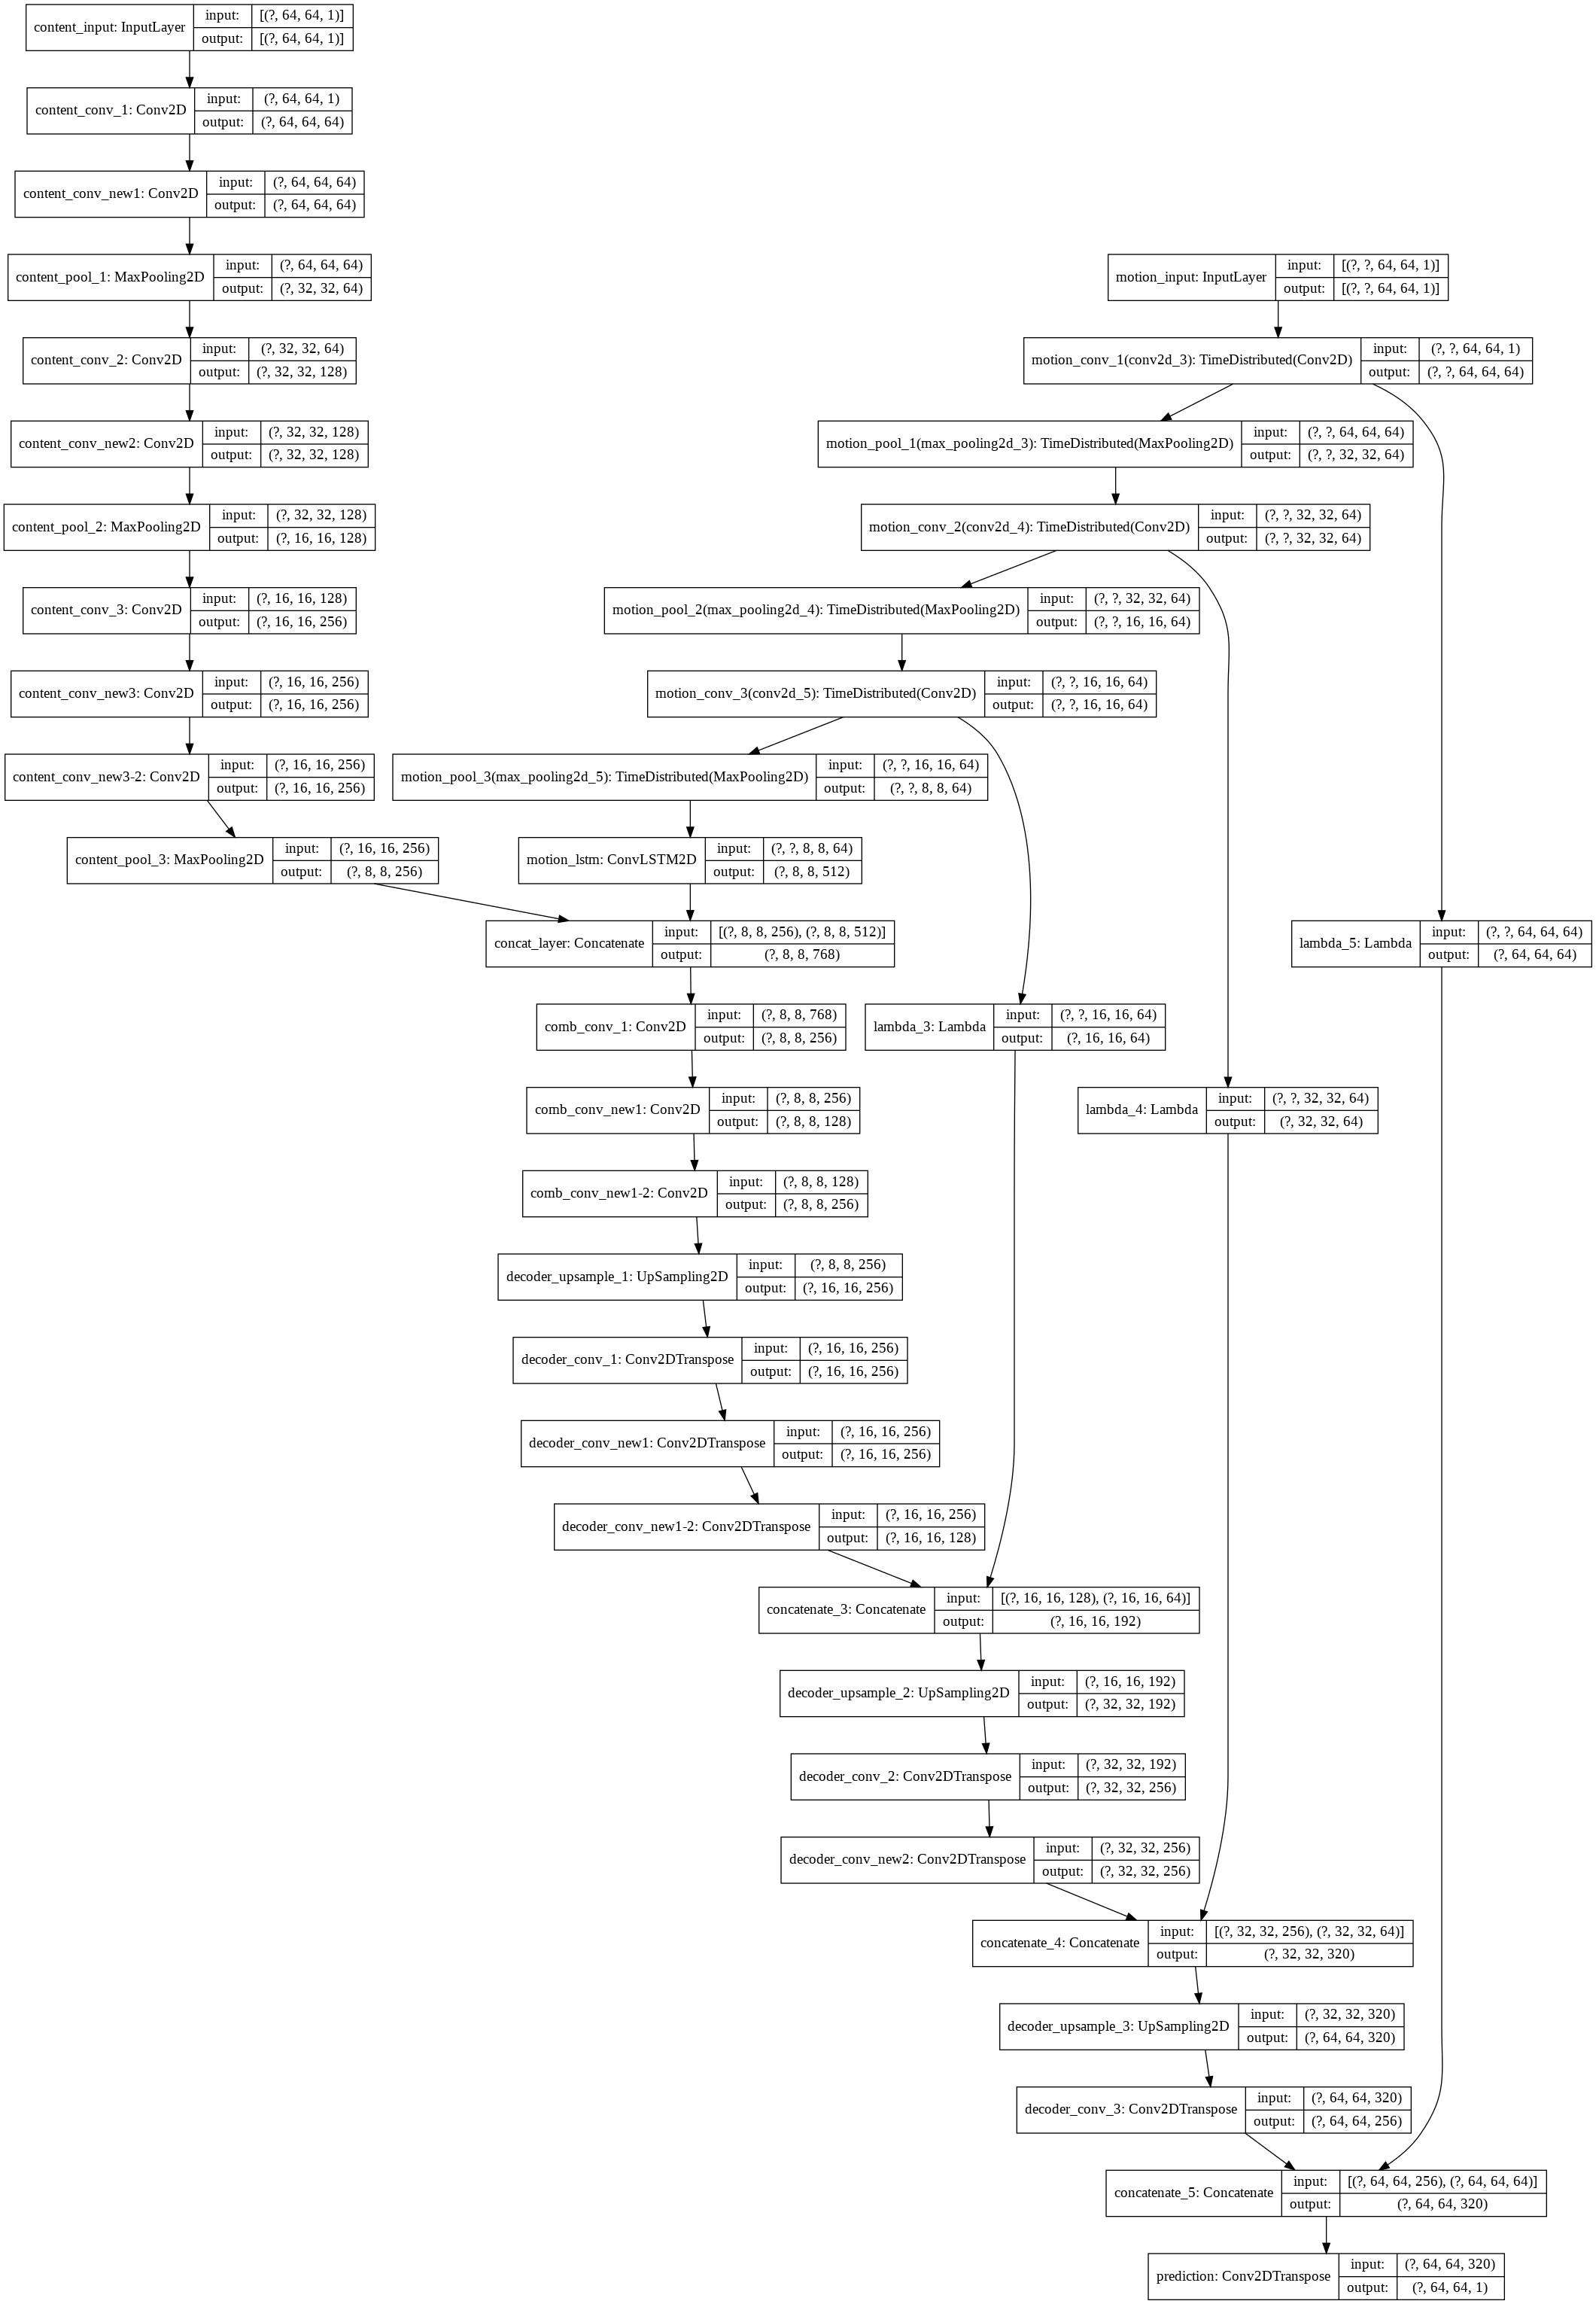

In [39]:
#Visualise Model Topology and save to file (model.png)
from tensorflow.compat.v1.keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='model.png')

In [0]:
#Save model
model.save('Model2_Nowcasting_(CoderDecoder_Arch).h5')

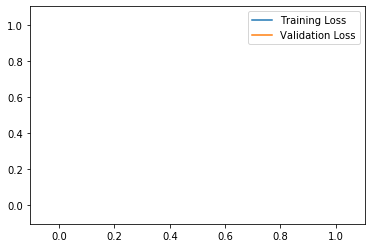

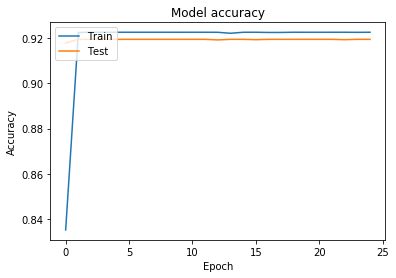

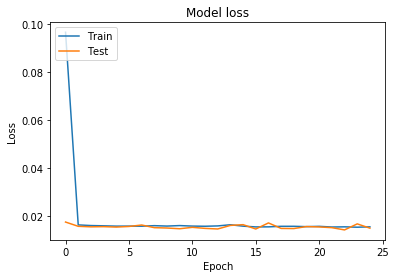

In [41]:
#Plot Training Loss vs. Validation Loss
plt.plot(loss_history.epochs['train'][2:], label='Training Loss')
plt.plot(loss_history.epochs['val'][2:], label='Validation Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [42]:
# evaluate the model
scores = model.evaluate(val_x, val_y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100)) #acc
print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100)) #ssim
print("%s: %.2f%%" % (model.metrics_names[4], scores[4]*100)) #POD #recall
print("%s: %.2f%%" % (model.metrics_names[5], scores[5]*100)) #FAR

acc: 91.95%
ssim: 43.62%
POD: 19.93%
FAR: 82.15%


In [0]:
performance_history = {
    'batches':loss_history.batches,
    'epochs':loss_history.epochs
    }
with open('model_loss_history.txt', 'w') as f:
    print(performance_history, file=f)

In [0]:
# Uncomment to 
# Load model from storage

#model_dir = '/'
#model = load_model(Path(model_dir, 'Model2_Nowcasting_(CoderDecoder_Arch).h5'))

In [0]:
def plot_prediction(seq_idx, plot_gt=False, use_own_predictions=False, show_label=True):
    for i, which in enumerate(seq_idx):

        if show_label: print(f"({i+1}) : {which}")

        input_length = 8 # length of input sequence
        prediction_length = 8 # length of prediction
        ground_truth = xs[which:which+1] # ground truth sequence


        if use_own_predictions:
            print("Use_own_prediction = True")
            pred = xs[which:which+1,input_length-1] # current frame, (1, 64, 64, 1)
            print(pred.shape)
            input_seq = ground_truth[:,0:input_length] # input sequence (first <inputLen> frames)   ,  (1, 10, 64, 64, 1)
            print(input_seq.shape)
            for i in range(input_length):
                # Model predicts next frame
                pred = model.predict([pred, motion_diff(input_seq)]) # return shape: (1, 64, 64, 1)
                # Cut first frame from sequence
                input_seq = np.squeeze(input_seq, axis=0)
                input_seq = input_seq[1:]
                # Append predicted frame to sequence
                input_seq = np.append(input_seq, pred, axis=0)
                input_seq = np.array([input_seq]) 
            predictions = input_seq
        
        else:
            # Use ground truth in each time step as input
            print("Use_own_prediction = False")
            print("Use Ground truth in each time step as input")
            predictions = []
            for i in range(prediction_length):
                input_seq = ground_truth[:, i:input_length+i]
                prediction = model.predict([input_seq[:,-1], motion_diff(input_seq)])
                predictions.append(prediction[0])
            predictions = np.array([predictions])
        
        figures=(input_length*2, 1)
        #figures=(input_length+prediction_length, 1)
        
        # Plot the ground truth sequence
        if plot_gt:
            fig,axs = plt.subplots(1, input_length+prediction_length, figsize=figures); cnt=0
            for col in axs:
                col.imshow(np.squeeze(ground_truth[0,cnt], axis=2))
                col.axis('off')
                cnt += 1   


        # Plot the input and predicted sequence
        fig,axs = plt.subplots(1, input_length+prediction_length, figsize=figures); cnt=0
        for col in axs:
            if cnt < input_length:
                col.imshow(np.squeeze(ground_truth[0,cnt], axis=2))
            else:
                col.imshow(np.squeeze(predictions[0,cnt-input_length],axis=2))
            col.axis('off')
            cnt += 1    
        
        plt.show()

(1) : 2
Use_own_prediction = True
(1, 64, 64, 1)
(1, 8, 64, 64, 1)


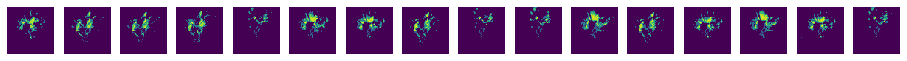

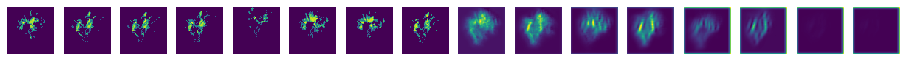

In [63]:
plot_prediction([2], plot_gt = True, use_own_predictions=True, show_label=True)

(1) : 6
Use_own_prediction = False
Use Ground truth in each time step as input


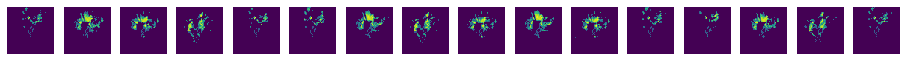

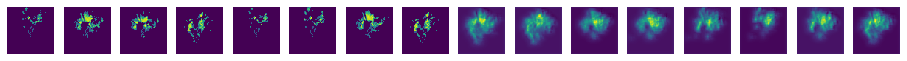

In [64]:
plot_prediction([6], plot_gt = True, use_own_predictions=False, show_label=True)

**END**